In [1]:
import os   
import sys
import yaml
import torch
import datetime
import pickle
import pytorch_lightning as pl
import torch.utils.data as data
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.append('/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE')
from srsphere.diffusion.diffusion import Diffusion
from srsphere.diffusion.schedules import TimestepSampler, linear_beta_schedule
from srsphere.diffusion.ResUnet_timeembed import Unet
from srsphere.data.maploader import get_datasets, transform_combine
from srsphere.diffusion.main import initialize, Unet_pl

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
ckpt_path= "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/lightning_logs/version_5/checkpoints/Run_09-04_18-05epoch=286-val_loss=0.03.ckpt"

# load config

In [4]:
config_file = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/params.yaml"
config_dict = initialize(config_file)

pl.seed_everything(1234)

CONDITIONAL = bool(config_dict['data']['conditional'])
BATCH_SIZE = 48#config_dict['train']['batch_size']

[rank: 0] Global seed set to 1234


In [5]:
### get training data
map_dirs = [config_dict['data']['hrmaps_dir'], config_dict['data']['lrmaps_dir']]
nsides = [config_dict['data']['nside_hr'], config_dict['data']['nside_lr']]
data_lr, data_hr = get_datasets(map_dirs, config_dict['data']['n_maps'], nsides, config_dict['data']['order'], config_dict['data']['issplit'], config_dict['data']['normalize'])
combined_dataset = transform_combine(data_hr - data_lr, data_lr)

len_train = int(config_dict['data']['rate_train'] * len(data_hr))
len_val = len(data_hr) - len_train
train, val = data.random_split(combined_dataset, [len_train, len_val])
loaders = {x: data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=x=='train', num_workers=os.cpu_count()) for x, ds in zip(('train', 'val'), (train, val))}

train_loader, val_loader= loaders['train'], loaders['val']

In [67]:
mapdir_lr = glob.glob(map_dirs[1]+"*.fits")

In [68]:
mapdir_lr

['/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_31823_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_20634_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_18517_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_17416_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_17933_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_27049_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_27140_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_2797_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_20721_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_1227_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_26802_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_6794_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_6706_0.00_64.fits',
 '/gpfs02/work/akira.tokiwa/gpgpu/FastPM/LR/z00/LR_18025_0.00_64.fit

In [6]:
timesteps = int(config_dict['diffusion']['timesteps'])

In [7]:
sampler = TimestepSampler(timesteps=timesteps, **config_dict['diffusion']['sampler_args'])

Sampler type uniform


# sampler

In [8]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [9]:
t = sampler.get_timesteps(48, 0).to(device)

In [10]:
t = torch.tensor(np.ones(BATCH_SIZE)*(timesteps-1), device=device).long()

In [11]:
timesteps = int(config_dict['diffusion']['timesteps'])
beta_func = linear_beta_schedule
beta_args = config_dict['diffusion']['schedule_args']
betas = beta_func(timesteps=timesteps, **beta_args)
tmp_diffusion = Diffusion(betas)

In [12]:
tmp_sample =combined_dataset.tensors[0][:BATCH_SIZE].to(device)
tmp_lr = combined_dataset.tensors[1][:BATCH_SIZE].to(device)

In [13]:
q_sample = tmp_diffusion.q_sample(tmp_sample, t)

In [14]:
diffused_sample = np.hstack(q_sample.detach().cpu().numpy()[:48, : , 0])
original_sample = np.hstack(tmp_sample.detach().cpu().numpy()[:48, : , 0])
lr_sample = np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])

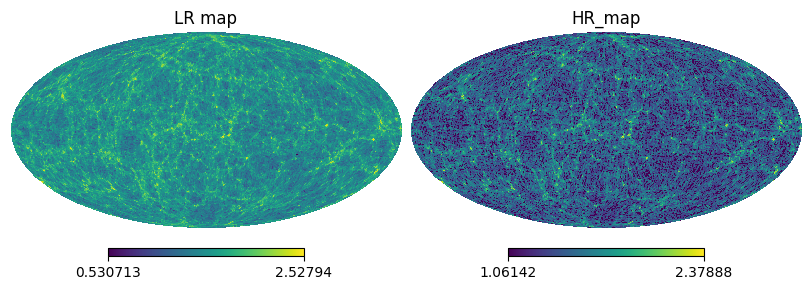

In [15]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR map', sub=(1,2,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,2,2))
fig.show()

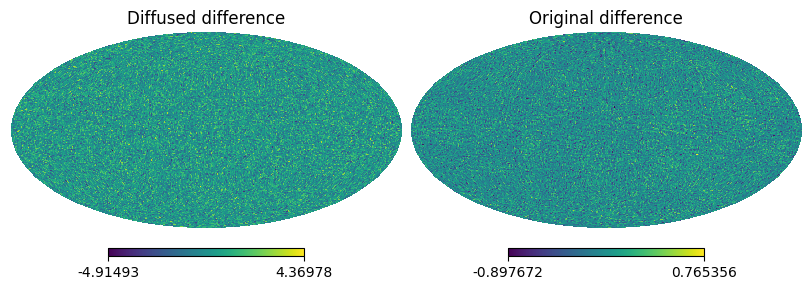

In [16]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(diffused_sample, nest=True, fig=fig, title='Diffused difference', sub=(1,2,1))
p2 = hp.mollview(original_sample, nest=True, fig=fig, title='Original difference', sub=(1,2,2))
fig.show()

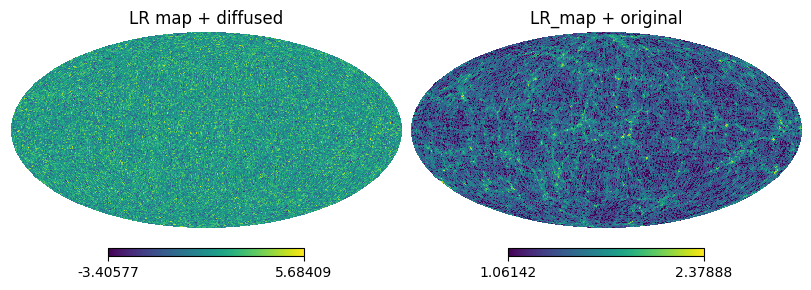

In [17]:
fig = plt.figure(figsize=(8,4))
p1 = hp.mollview(diffused_sample + lr_sample, nest=True, fig=fig, title='LR map + diffused', sub=(1,2,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='LR_map + original', sub=(1,2,2))
fig.show()

# load state dict

In [18]:
ckpt = torch.load(ckpt_path)

In [19]:
model = Unet_pl(Unet, config_dict, sampler = sampler).to(device)
model.load_state_dict(ckpt["state_dict"], strict=False)

_IncompatibleKeys(missing_keys=['model.init_conv.laplacian', 'model.init_conv_lr.laplacian', 'model.down_blocks.0.0.block1.conv.laplacian', 'model.down_blocks.0.0.block2.conv.laplacian', 'model.down_blocks.0.1.block1.conv.laplacian', 'model.down_blocks.0.1.block2.conv.laplacian', 'model.down_blocks.1.0.block1.conv.laplacian', 'model.down_blocks.1.0.block2.conv.laplacian', 'model.down_blocks.1.0.res_conv.laplacian', 'model.down_blocks.1.1.block1.conv.laplacian', 'model.down_blocks.1.1.block2.conv.laplacian', 'model.down_blocks.2.0.block1.conv.laplacian', 'model.down_blocks.2.0.block2.conv.laplacian', 'model.down_blocks.2.0.res_conv.laplacian', 'model.down_blocks.2.1.block1.conv.laplacian', 'model.down_blocks.2.1.block2.conv.laplacian', 'model.down_blocks.3.0.block1.conv.laplacian', 'model.down_blocks.3.0.block2.conv.laplacian', 'model.down_blocks.3.0.res_conv.laplacian', 'model.down_blocks.3.1.block1.conv.laplacian', 'model.down_blocks.3.1.block2.conv.laplacian', 'model.mid_block1.block

In [20]:
model.eval()

Unet_pl(
  (model): Unet(
    (pooling): HealpixAvgPool(kernel_size=(4,), stride=(4,), padding=(0,))
    (unpooling): HealpixAvgUnpool()
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=64, out_features=64, bias=True)
    )
    (init_conv): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (init_conv_lr): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (down_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock_t(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=64, out_features=64, bias=True)
          )
          (block1): Block(
            (conv): SphericalChebConv(
              (chebconv): ChebConv()
            )
            (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
            (act): LeakyReLU(negative_slope=0.1)
          )
          (block2): Bl

# test

In [21]:
from tqdm.auto import tqdm

In [28]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

In [35]:
def plot_ps(input_cl, output_cl, target_cl):
    fig = plt.figure(figsize=(10, 5))
    ell = np.arange(len(input_cl))
    plt.plot(ell*(ell+1)*input_cl/(2*np.pi), label="input")
    plt.plot(ell*(ell+1)*output_cl/(2*np.pi), label="output")
    plt.plot(ell*(ell+1)*target_cl/(2*np.pi), label="target")
    #plt.ylim(0,2)
    plt.xlabel("l", fontsize=16)
    plt.ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=16)
    plt.yscale("log")
    plt.legend(fontsize=16)
    plt.show()

In [25]:
q_sample = tmp_diffusion.q_sample(tmp_sample, torch.full((BATCH_SIZE,), timesteps-1, device=device))

In [43]:
img = torch.randn(tmp_sample.shape, device=device)
imgs = []

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long)
    img = tmp_diffusion.p_sample(model.model, img, t, tmp_lr, i)
    imgs.append(img.detach().cpu().numpy()[:48, : , 0])

sampling loop time step: 100%|██████████| 1000/1000 [19:44<00:00,  1.18s/it]


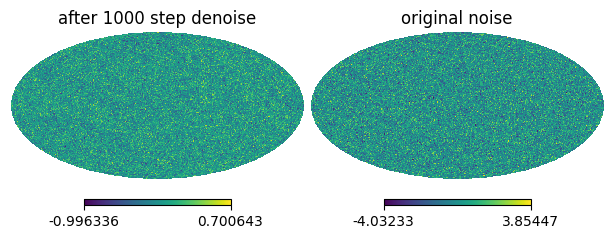

In [50]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(np.hstack(imgs[-1]), nest=True, fig=fig, title='after 1000 step denoise', sub=(1,2,1))
f2 = hp.mollview(np.hstack(imgs[0]), nest=True, fig=fig, title='original noise', sub=(1,2,2))

In [51]:
res=np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + np.hstack(imgs[-1])

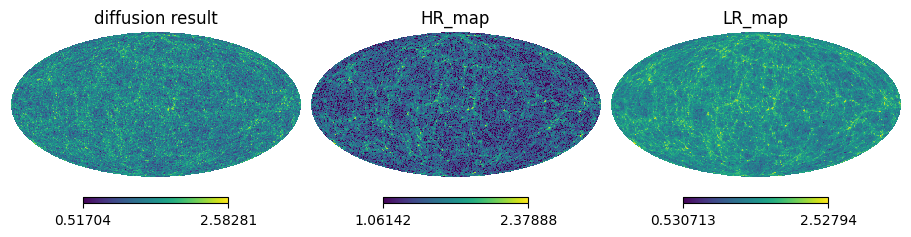

In [52]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

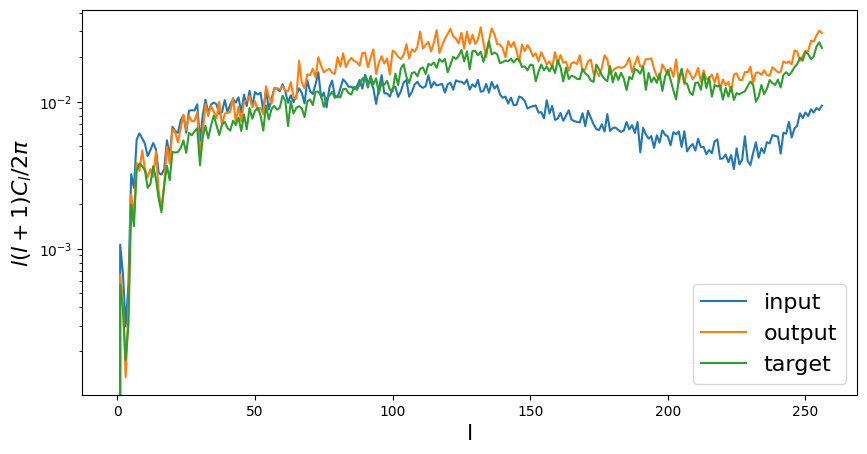

In [58]:
lmax = 64*4

input_cl =hp.sphtfunc.anafast(t2hpr(lr_sample), lmax=lmax)
output_cl =hp.sphtfunc.anafast(t2hpr(res), lmax=lmax)
target_cl =hp.sphtfunc.anafast(t2hpr(original_sample + lr_sample), lmax=lmax)

plot_ps(input_cl, output_cl, target_cl)

In [44]:
n = 5
tick = 500//n
for i in range(n):
    fig = plt.figure(figsize=(4,4))
    c = hp.mollview(np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])+imgs[tick*i], nest=True,  fig=fig)
    plt.show()

ValueError: operands could not be broadcast together with shapes (49152,) (48,1024) 

<Figure size 400x400 with 0 Axes>

In [26]:
diffused_sample = np.hstack(q_sample.detach().cpu().numpy()[:48, : , 0])

In [36]:
img = q_sample.detach()
imgs=[np.hstack(img.detach().cpu().numpy()[:48, : , 0])]

In [37]:
i = 999
t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long)
predicted_noise = model.model(img, t, tmp_lr)
img = (img - predicted_noise)
imgs.append(np.hstack(img.detach().cpu().numpy()[:48, : , 0]))
del predicted_noise 
torch.cuda.empty_cache()

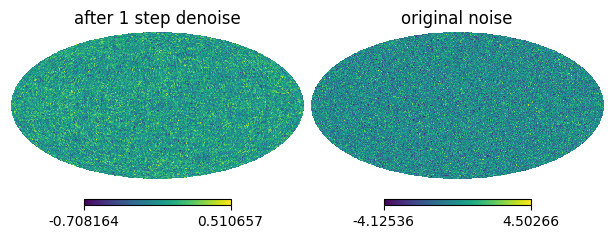

In [38]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(imgs[1], nest=True, fig=fig, title='after 1 step denoise', sub=(1,2,1))
f2 = hp.mollview(imgs[0], nest=True, fig=fig, title='original noise', sub=(1,2,2))

In [63]:
img = q_sample.detach()
imgs=[img]
for i in tqdm(reversed(range(0, timesteps-1)), desc='sampling loop time step', total=timesteps):
    t = torch.full((BATCH_SIZE,), i, device=device, dtype=torch.long).detach()
    predicted_noise = model.model(img, t, tmp_lr).detach()
    img = (img - predicted_noise).detach()
    imgs.append(np.hstack(img.detach().cpu().numpy()[:48, : , 0]))
    del predicted_noise 
    torch.cuda.empty_cache()

sampling loop time step:   0%|          | 3/1000 [00:04<24:33,  1.48s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 180.00 MiB (GPU 0; 31.74 GiB total capacity; 30.81 GiB already allocated; 89.06 MiB free; 31.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [47]:
res=np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + imgs[-1]

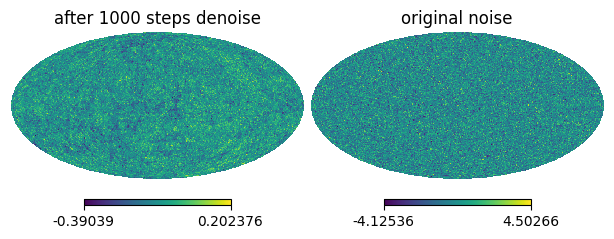

In [55]:
fig = plt.figure(figsize=(6,4))
f1 = hp.mollview(imgs[-1], nest=True, fig=fig, title='after 1000 steps denoise', sub=(1,2,1))
f2 = hp.mollview(diffused_sample, nest=True, fig=fig, title='original noise', sub=(1,2,2))

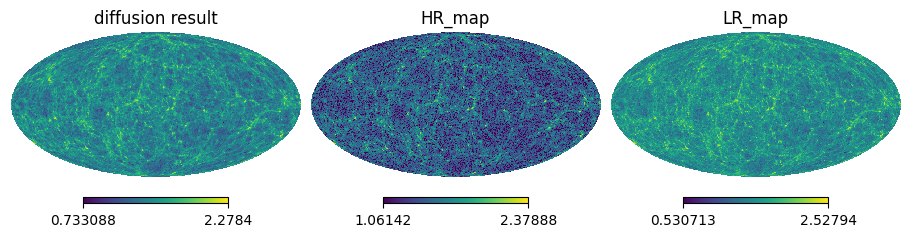

In [48]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

In [49]:


lmax = 64*3

input_cl =hp.sphtfunc.anafast(t2hpr(res), lmax=lmax)
output_cl =hp.sphtfunc.anafast(t2hpr(original_sample + lr_sample), lmax=lmax)
target_cl =hp.sphtfunc.anafast(t2hpr(lr_sample), lmax=lmax)

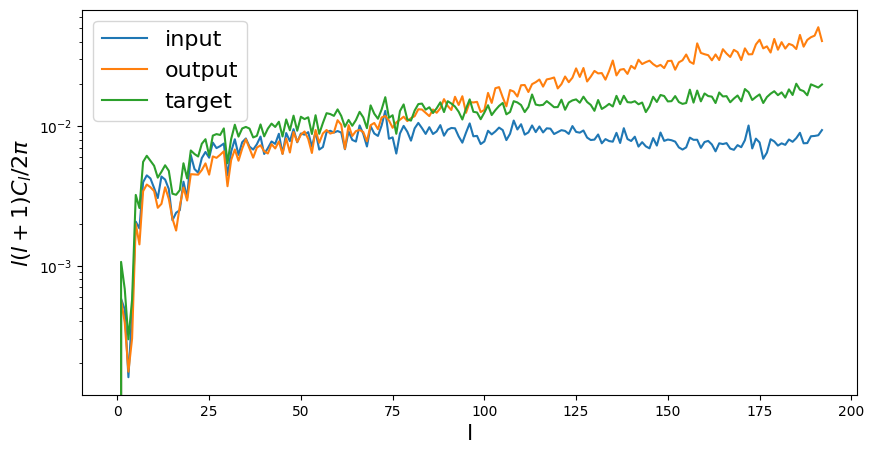

In [51]:
plot_ps(input_cl, output_cl, target_cl)

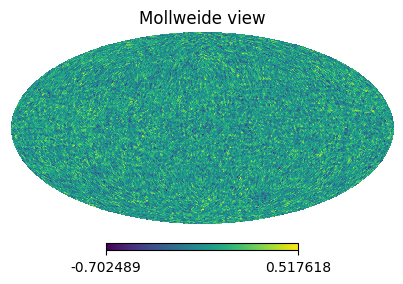

In [60]:
fig = plt.figure(figsize=(4,4))
c = hp.mollview(imgs[0], nest=True,  fig=fig)
plt.show()

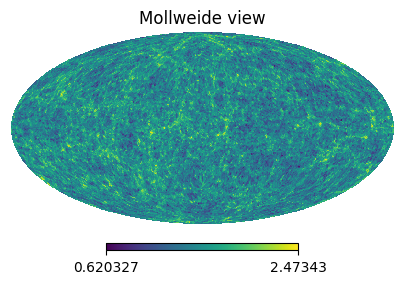

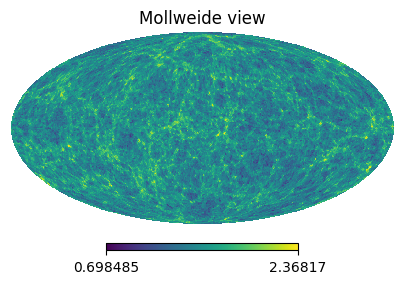

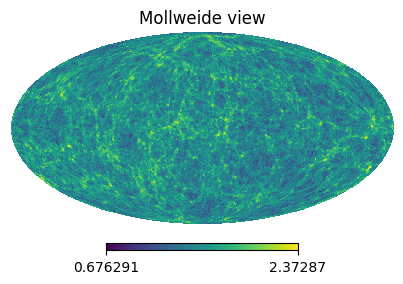

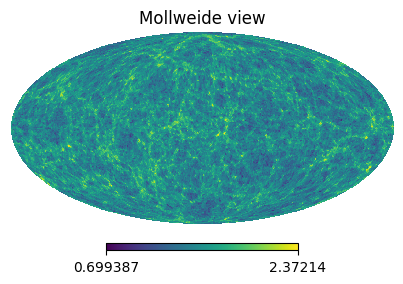

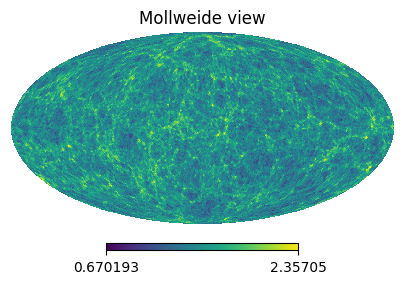

In [58]:
n = 5
tick = 500//n
for i in range(n):
    fig = plt.figure(figsize=(4,4))
    c = hp.mollview(np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0])+imgs[tick*i], nest=True,  fig=fig)
    plt.show()

In [58]:
dfs = model.diffusion

In [69]:
shape = tmp_sample.shape
b = shape[0]
img = torch.randn(shape, device=device)
imgs = []
for i in tqdm(reversed(range(0, dfs.timesteps, 10)), desc='sampling loop time step', total=dfs.timesteps//10):
    img = dfs.p_sample(model.model, img, torch.full((b,), i, device=device, dtype=torch.long), tmp_lr, i, None).detach()
    imgs.append(img.cpu().numpy())

sampling loop time step: 100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


In [77]:
res = np.hstack(tmp_lr.detach().cpu().numpy()[:48, : , 0]) + np.hstack(imgs[-1][:48, : , 0])

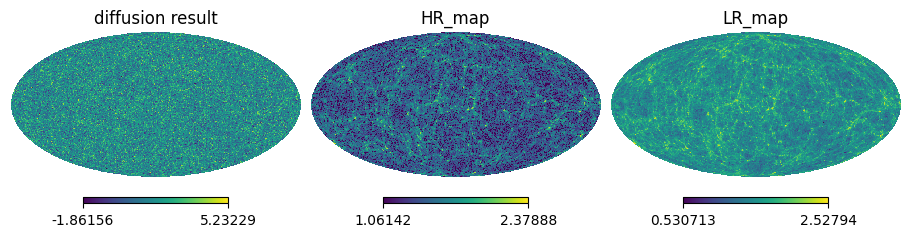

In [79]:
fig = plt.figure(figsize=(9,4))
p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,3,1))
p2 = hp.mollview(original_sample + lr_sample, nest=True, fig=fig, title='HR_map', sub=(1,3,2))
p3 = hp.mollview(lr_sample, nest=True, fig=fig, title='LR_map', sub=(1,3,3))
fig.show()

# statistics

In [10]:
import glob

In [15]:
data_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/srsphere/diffusion/result/"

In [21]:
combined_dataset.tensors[1].shape

torch.Size([4800, 1024, 1])

In [51]:
lmax = 64*4

input_cl =[]
output_cl =[]
target_cl =[]

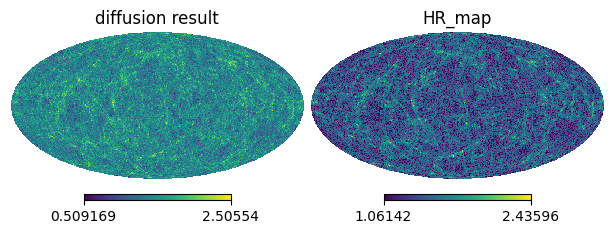

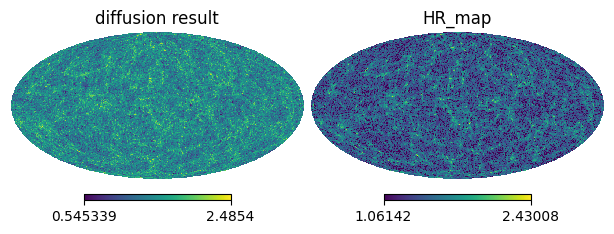

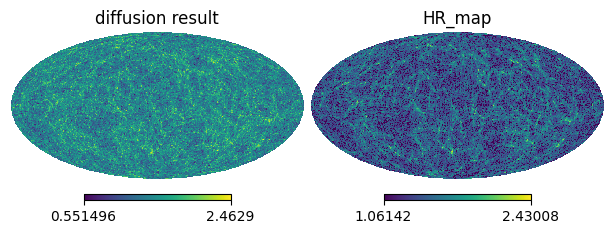

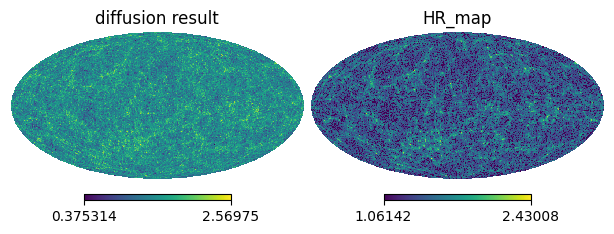

In [52]:
for i in range(100):
    fname = data_dir+f"diffused_{i}.fits"
    tmp_lr = np.hstack(combined_dataset.tensors[1][48*i:48*(i+1)].detach().cpu().numpy()[:48, : , 0])
    tmp_sample = np.hstack(combined_dataset.tensors[0][48*i:48*(i+1)].detach().cpu().numpy()[:48, : , 0])
    tmp = hp.read_map(fname)
    res=tmp_lr + tmp
    tmp_hr = tmp_lr + tmp_sample
    output_cl.append(hp.sphtfunc.anafast(t2hpr(res), lmax=lmax))
    input_cl.append(hp.sphtfunc.anafast(t2hpr(tmp_lr), lmax=lmax))
    target_cl.append(hp.sphtfunc.anafast(t2hpr(tmp_hr), lmax=lmax))
    if (i+1)%25==0:
        fig = plt.figure(figsize=(6,3))
        p1 = hp.mollview(res, nest=True, fig=fig, title='diffusion result', sub=(1,2,1))
        p2 = hp.mollview(tmp_hr, nest=True, fig=fig, title='HR_map', sub=(1,2,2))
        fig.show()

In [53]:
input_cl=np.mean(input_cl, axis=0)
output_cl=np.mean(output_cl, axis=0)
target_cl=np.mean(target_cl, axis=0)

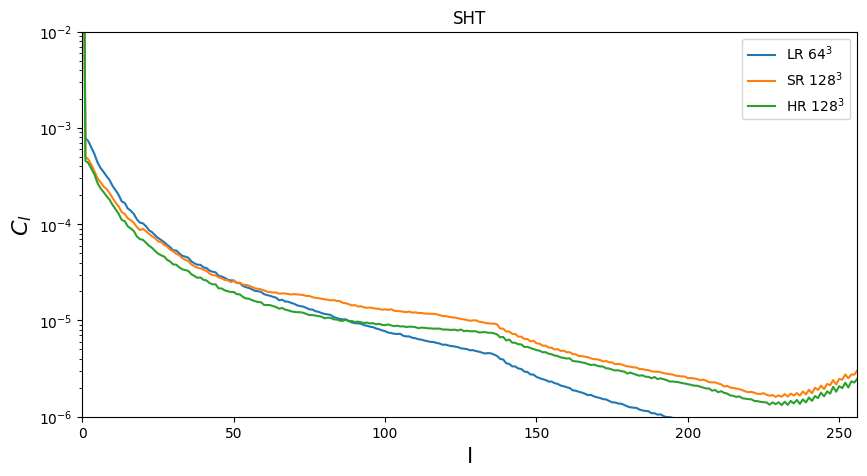

In [73]:
fig = plt.figure(figsize=(10, 5))
ell = np.arange(len(input_cl))
plt.plot(ell,input_cl, label=r"LR $64^3$")
plt.plot(ell,output_cl, label=r"SR $128^3$")
plt.plot(ell,target_cl, label=r"HR $128^3$")
#plt.vlines(64*2, 10**-7, 10**1, color="red")
plt.xlim([0, lmax])
plt.ylim([10**-6, 10**-2])
plt.title('Spherical Harmonics Tranformation')
plt.xlabel("l", fontsize=16)
plt.ylabel(r"$C_{l}$", fontsize=16)
plt.yscale("log")
plt.legend()

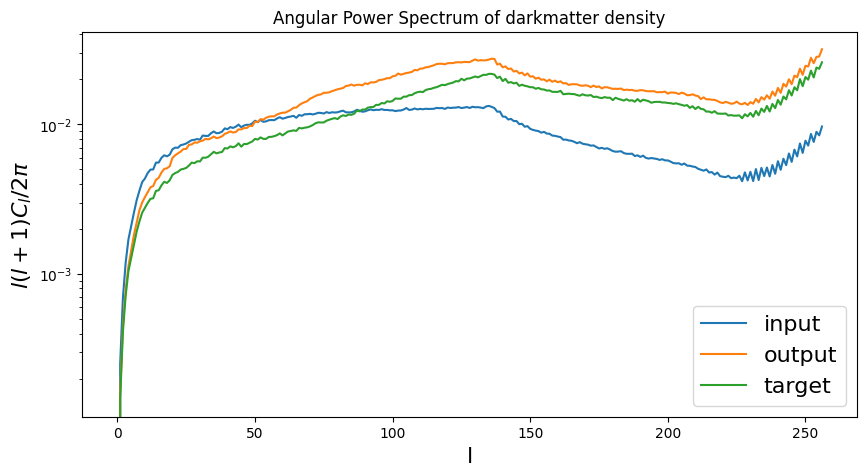

In [72]:
fig = plt.figure(figsize=(10, 5))
ell = np.arange(len(input_cl))
plt.plot(ell*(ell+1)*input_cl/(2*np.pi), label="input")
plt.plot(ell*(ell+1)*output_cl/(2*np.pi), label="output")
plt.plot(ell*(ell+1)*target_cl/(2*np.pi), label="target")
#plt.ylim(0,2)
plt.xlabel("l", fontsize=16)
plt.ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=16)
plt.title('Angular Power Spectrum of darkmatter density')
plt.show()